# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация

Дата выдачи: 30.01.2025

Мягкий дедлайн: 23:59MSK 16.02.2025

Жесткий дедлайн: 23:59MSK 23.02.2025

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). 

Использование генеративных языковых моделей разрешено только в случае явного указания на это. Необходимо прописать (в соответствующих пунктах, где использовались, либо в начале/конце работы):
- какая языковая модель использовалась
- какие использовались промпты и в каких частях работы
- с какими сложностями вы столкнулись при использовании генеративных моделей, с чем они помогли больше всего

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

In [2]:
%load_ext autoreload
%autoreload 2

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [3]:
import numpy as np

# 1 Способ 
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()

# 2 Способ (если первый не работает)
# from sklearn.datasets import fetch_openml
# def load_fashion_mnist():
#     X, y = fetch_openml('Fashion-MNIST', version=1, return_X_y=True, as_frame=False)
#     X = X.reshape(-1, 28, 28).astype('uint8')
#     y = y.astype('int64')
#     x_train, x_test = X[:60000], X[60000:]
#     y_train, y_test = y[:60000], y[60000:]
#     return (x_train, y_train), (x_test, y_test)
# (x_train_pics, y_train), (x_test_pics, y_test) = load_fashion_mnist()




x_train = x_train_pics.reshape(y_train.shape[0], -1)
x_test = x_test_pics.reshape(y_test.shape[0], -1)

__Задание 0. (0.25 баллов)__

**Вопрос:** зачем в алгоритме нужен метод главных компонент? 

**Ответ:** Чтобы порезать количество признаков и улучшить тем самым производительность при вычислении и возможно чтобы мы работали с преобразованиями признаков с самым большим вкладом 

__Задание 1. (3 балла)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса в `homework_practice_08_rff.py` (допишите его и исправьте несостыковки в классе пайплайна) или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [119]:
from homework_practice_08_rff import RFFPipeline, RandomFeatureCreator
from sklearn.metrics import accuracy_score

pipeline = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=RandomFeatureCreator)
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
accuracy_rand = accuracy_score(y_test, y_pred)
accuracy_rand

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8542

Получилось больше 0.84, гоооол

__Задание 2. (2.5 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучите градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost. 

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

In [36]:
from sklearn.svm import LinearSVC as svc 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


clf = make_pipeline(StandardScaler(),
                    svc(random_state=0, tol=1e-5))
clf.fit(x_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(random_state=0, tol=1e-05))])

In [38]:
y_pred = clf.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.8371

In [44]:
import polars as pl 
accuracies = pl.DataFrame({'random_features': [accuracy_rand], 'linear_svm': [accuracy]})
accuracies

random_features,linear_svm
f64,f64
0.851,0.8371


In [65]:
from sklearn import svm 
rbf_svc = svm.SVC(kernel='rbf')
indices = np.random.choice(x_train.shape[0], 20000)
x_train_cut = x_train[indices, :]
y_train_cut = y_train[indices]
model_2 = rbf_svc.fit(x_train_cut, y_train_cut)
y_pred_2 = model_2.predict(x_test)

In [87]:
accuracy_kernal = accuracy_score(y_test, y_pred_2)
accuracies = accuracies.with_columns(pl.lit(accuracy_kernal).alias('kernal_svm'))

In [83]:
from sklearn.decomposition import PCA
from catboost import CatBoostClassifier
new_dim = 50
boosting_pipeline = make_pipeline(StandardScaler(),
                    PCA(random_state=0, n_components=new_dim),
                    CatBoostClassifier())
boosting_pipeline.fit(x_train, y_train)

Learning rate set to 0.097501
0:	learn: 1.9552513	total: 90.2ms	remaining: 1m 30s
1:	learn: 1.7681334	total: 121ms	remaining: 1m
2:	learn: 1.6144115	total: 152ms	remaining: 50.7s
3:	learn: 1.4919476	total: 182ms	remaining: 45.4s
4:	learn: 1.3976850	total: 212ms	remaining: 42.2s
5:	learn: 1.3157955	total: 247ms	remaining: 41s
6:	learn: 1.2557804	total: 279ms	remaining: 39.6s
7:	learn: 1.2049988	total: 309ms	remaining: 38.3s
8:	learn: 1.1493626	total: 340ms	remaining: 37.4s
9:	learn: 1.0973822	total: 373ms	remaining: 37s
10:	learn: 1.0543944	total: 407ms	remaining: 36.6s
11:	learn: 1.0199641	total: 442ms	remaining: 36.4s
12:	learn: 0.9803695	total: 475ms	remaining: 36s
13:	learn: 0.9479330	total: 505ms	remaining: 35.6s
14:	learn: 0.9180939	total: 538ms	remaining: 35.3s
15:	learn: 0.8954354	total: 568ms	remaining: 35s
16:	learn: 0.8708870	total: 599ms	remaining: 34.6s
17:	learn: 0.8485468	total: 631ms	remaining: 34.4s
18:	learn: 0.8283142	total: 666ms	remaining: 34.4s
19:	learn: 0.8087566

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=50, random_state=0)),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x2abc697c0>)])

In [88]:
y_pred_cat = boosting_pipeline.predict(x_test)
accuracy_cat = accuracy_score(y_test, y_pred_cat)
accuracies = accuracies.with_columns(pl.lit(accuracy_cat).alias('svm_catboost'))

In [127]:
accuracies

random_features,linear_svm,kernal_svm,svm_catboost
f64,f64,f64,f64
0.8542,0.8371,0.8662,0.8706


По времени:

Случайные признаки + PCA: около 17 секунд

LinearSVM: 26 минут ☠️

KernalSVM с подвыборкой в 20000: минута 17 секунд 

PCA + CatBoost: 32 секунды 

Лучший результат по времени показал метод случайных признаков с аппроксимацией и использованием PCA для снижения размерности

Худший по времени: LinearSVM

По качеству же лучшим оказался кэтбуст, далее ядровой SVM с подвыборкой и после этого случайные признаки

Оптимальный метод по времени/качеству очевидно кэтбуст, случайные признаки чуть побыстрее, но качество хуже, чем у ядрового, который зато в несколько раз медленнее и зависит от выбора ядра 


__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

Проверим по качеству помогает ли понижение размерности с помощью PCA

In [92]:
pipeline_no_PCA = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=RandomFeatureCreator, use_PCA=False)
pipeline_no_PCA.fit(x_train, y_train)
y_pred = pipeline_no_PCA.predict(x_test)
accuracy_no_PCA = accuracy_score(y_test, y_pred)
accuracy_no_PCA

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8604

Получаем, что понижение размености помогает со скоростью (42 секунды vs 17 секунд), но чуть-чуть режет качество

Теперь проверим как зависит итоговое качество от n_features 

In [113]:
features_range = [5, 10, 50, 100, 200, 500, 1000]
accuracies_test_n_features = []
for cur_range in features_range:
    iter_pipeline = RFFPipeline(n_features=cur_range, new_dim=50, feature_creator_class=RandomFeatureCreator, use_PCA=True)
    iter_pipeline.fit(x_train, y_train)
    y_pred_iter = iter_pipeline.predict(x_test)
    accuracies_test_n_features.append(accuracy_score(y_test, y_pred_iter))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Теперь возьмем рэндж выше тысячи и посмотрим выходит ли на плато

In [114]:
features_range = [2000, 3000, 4000, 5000, 10000]
for cur_range in features_range:
    iter_pipeline = RFFPipeline(n_features=cur_range, new_dim=50, feature_creator_class=RandomFeatureCreator, use_PCA=True)
    iter_pipeline.fit(x_train, y_train)
    y_pred_iter = iter_pipeline.predict(x_test)
    accuracies_test_n_features.append(accuracy_score(y_test, y_pred_iter))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

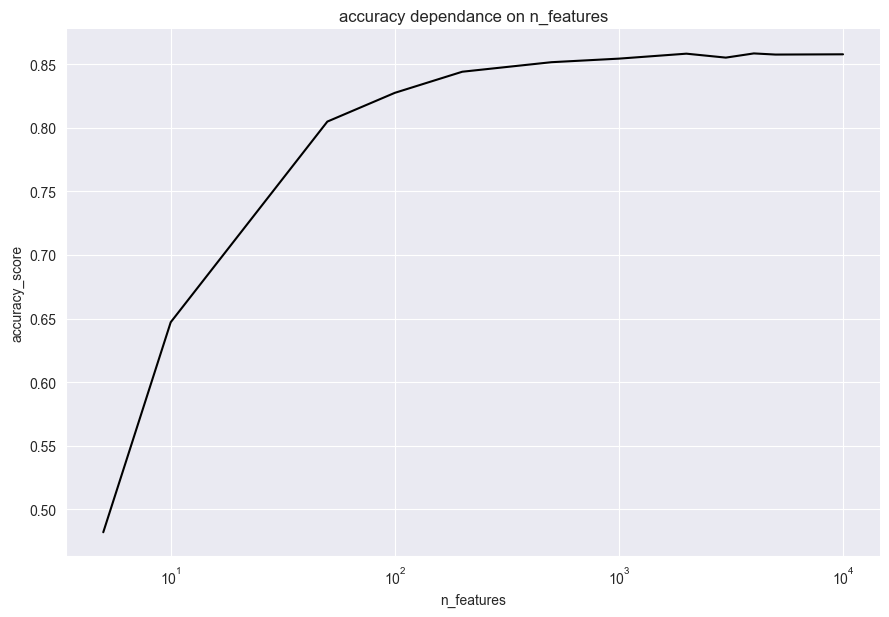

In [115]:
import seaborn as sns
sns.set_style('darkgrid')
sns.relplot(x=[5, 10, 50, 100, 200, 500, 1000, 2000, 3000, 4000, 5000, 10000], 
             y=accuracies_test_n_features,
             kind='line', height=6, aspect=1.5, color='black').set(xscale='log', title='accuracy dependance on n_features', xlabel='n_features', ylabel='accuracy_score')

Как можно увидеть, качество действительно выходит на плато в районе n_features=1000, далее качество улучшается совсем немного, даже при 10000 

Теперь посмотрим есть ли разница обучать линейную модель или SVM во время нашего случайного отбора признаков)))))))

In [ ]:

pipeline_linear = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=RandomFeatureCreator, classifier_class = svc, use_PCA=True)
pipeline_linear.fit(x_train, y_train)
y_pred = pipeline_linear.predict(x_test)
accuracy_linear_rand = accuracy_score(y_test, y_pred)
accuracy_linear_rand

0.8741

Получаем, что обучается в разы медленнее, но качество повыше, чем у логистической 

И вообще если сравнить с табличкой accuracies, то тут качество выше, чем везде получилось...

__Задание 4. (Максимум 1.5 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет), n_features=new_dim и n_features < new_dim также должны работать, убедитесь в этом. Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы. 


In [129]:
from homework_practice_08_rff import OrthogonalRandomFeatureCreator

pipeline = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=OrthogonalRandomFeatureCreator)
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
accuracy_ORF = accuracy_score(y_test, y_pred)
accuracy_ORF

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8575

Сравним работу для 20, 50 и 500 признаков и сравним accuracy:

In [143]:
nums = [20, 50, 500]
res = []
for num in nums:
    pipeline_num_orthogonal = RFFPipeline(n_features=num, new_dim=50, feature_creator_class=OrthogonalRandomFeatureCreator)
    pipeline_num_base = RFFPipeline(n_features=num, new_dim=50, feature_creator_class=RandomFeatureCreator)
    pipeline_num_orthogonal.fit(x_train, y_train)
    pipeline_num_base.fit(x_train, y_train)
    y_pred_orthogonla = pipeline_num_orthogonal.predict(x_test)
    y_pred_base = pipeline_num_base.predict(x_test)
    res.append((f'accuracy_score on {num} n_features: {accuracy_score(y_test, y_pred_base)} for base vs {accuracy_score(y_test, y_pred_orthogonla)} for orthogonal'))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

In [144]:
for i in range(len(nums)):
    print(res[i])

accuracy_score on 20 n_features: 0.7539 for base vs 0.7204 for orthogonal
accuracy_score on 50 n_features: 0.7994 for base vs 0.8163 for orthogonal
accuracy_score on 500 n_features: 0.8561 for base vs 0.8537 for orthogonal


Как видим RFF дает чуть лучшее качество 

__Задание 5. (Максимум 1 балл)__

Существует большое количество работ, где идея RFF развивается, предлагаются её обобщения (которые, по сути, выливаются в другие преобразования признаков, не обязательно уже тригонометрические). Возьмите любую из таких работ, кратко опишите идею, имплементируйте её и сравните качество с ORF и RFF, которые вы запрограммировали выше.

Ссылки на статьи, где обсуждаются вариации RFF для разных ядер, можно найти в окрестности таблицы 1 в работе https://arxiv.org/pdf/1407.5599  

___ссылка на работу:___

___описание идеи:___

In [ ]:
# лютый скип 

__Задание 6. (Максимум 2.5 балла)__

Реализуйте класс ядровой Ridge регрессии (Лекция 13, $\S 1.2$), для оптимизации используте градиентный спуск **[1 балл максимум]**, также добавьте возможность использовать аналитическую формулу **[1 балл максимум]**. Для градиентного спуска выпишите градиент ниже **[0.5 баллов максимум]**. 
Подумайте о том, как в формулах правильно учесть свободный коэффициент. 

Затем адаптируйте вашу реализацию RFF под задачу регрессии. Сравните вашу ядровую регрессию и RFF на синтетических данных.

Функция потерь: 
$$
Q(w) = \frac{1}{2} ||\Phi \Phi^T w - y||^2 + \frac{\lambda}{2} w^T \Phi \Phi^T w \rightarrow \min_w,
$$
где $\Phi \Phi^T = K$, $K = (k(x_i, x_j))_{i, j = 1}^{\ell}$.

Предсказание: 
$
y(x) = k(x)^T w,
$
где $k(x)$ — вектор функций ядра от пар объектов $(x, x_i)_{i=1}^{\ell}$.

___Выведите градиент:___ 
$$
d(Q(w)) = d(\frac{1}{2} ||\Phi \Phi^T w - y||^2 + \frac{\lambda}{2} w^T \Phi \Phi^T w) = \frac{1}{2} d(\Phi \Phi^T w - y)^T(\ \Phi \Phi^T w - y) + \frac{\lambda}{2} d(w^T \Phi \Phi^T w) = (\Phi \Phi^T = A) = \frac{1}{2} (d(w)^TA^T(A w - y) + (A w - y)^TAdw) + \frac{\lambda}{2} ((dw)^TAw + w^TAdw) =  \\ 
= \frac{1}{2} * 2(A w - y)^TAdw + \frac{\lambda}{2}(2w^TAdw) = ((A w - y)^TA + w^TA)dw \Rightarrow \\ \nabla = A(Aw - y) + Aw = \Phi \Phi^T(\Phi \Phi^Tw - y) + \lambda\Phi \Phi^Tw
$$

Вы можете изменять представленный шаблон в файле `homework_practice_08_kernel_regression.py` по своему усмотрению.

In [ ]:
from homework_practice_08_kernel_regression import KernelRidgeRegression #лол тоже скип